# Diversity of Ideas: Harvard Op-Eds

## Setup

In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [3]:
import pandas as pd
from util.ouraws import (
    getFromFile
)

In [4]:
%pwd

'c:\\Users\\theod\\OneDrive\\dev\\diversity-ideas\\notebooks\\2024'

In [5]:
df = getFromFile("../../data/harvard-op-eds.parquet", False)
df.shape


(3026, 6)

In [6]:
df.head(4)

,title,url,body,year,month,day
0,"Allston Is Gentrifying, but Harvard Isn’t To B...",https://www.thecrimson.com/article/2024/3/7/be...,"Allston Is Gentrifying, but Harvard Isn’t To B...",2024,3,1
1,Datamatch’s Flaws Run Deeper Than a Leak,https://www.thecrimson.com/article/2024/3/6/ra...,Datamatch’s Flaws Run Deeper Than a Leak\nBy T...,2024,3,1
2,"This Women’s History Month, I Find Myself in G...",https://www.thecrimson.com/article/2024/3/8/ch...,"This Women’s History Month, I Find Myself in G...",2024,3,1
3,A Safer River Run is a Better River Run,https://www.thecrimson.com/article/2024/3/5/me...,A Safer River Run is a Better River Run\nBy Ju...,2024,3,1


## Function Definitions

In [7]:
import numpy as np
import re

In [8]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [9]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [10]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [12]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.

In [13]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

## Analysis

In [14]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [15]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [16]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [18]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [19]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [20]:
type(wv[0])

list

In [21]:
docmatrix = np.array(wv)

In [22]:
docmatrix.shape

(158, 1024)

In [23]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

0       2024
1       2024
2       2024
3       2024
4       2024
        ... 
3021    2024
3022    2024
3023    2024
3024    2024
3025    2024
Name: year, Length: 160, dtype: int64, 158, 0.0009771209154201517, 0.4095502423123986


In [24]:
pairwise

0.4095502423123986

In [25]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = get_batch_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2009, 35, 0.000977197318309979, 0.5285812207403445
2010, 178, 0.000976933843628222, 0.5534608317490691
2011, 226, 0.0009769551346632001, 0.5352541520556333
2012, 264, 0.0009769316793116416, 0.5231907585973212
2013, 308, 0.0009770075348316037, 0.5266019422490074
2014, 303, 0.0009770203650151452, 0.5222070243592554
2015, 167, 0.0009770854226232209, 0.4900222722285264
2016, 173, 0.000976927660537869, 0.481940941825799
2017, 178, 0.0009770706766323537, 0.48529402355936613
2018, 167, 0.0009771179969599638, 0.46253995241369783
2019, 166, 0.000977159499528183, 0.431260354623559
2020, 183, 0.000977120080960458, 0.4475430383959
2021, 157, 0.0009771158863246755, 0.44788091076763215
2022, 167, 0.0009771508206002984, 0.4682413392265164
2023, 174, 0.0009771318384947964, 0.4569818162715192
2024, 158, 0.0009771218671206134, 0.4095312468837537


In [26]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.528581,35,0.000977,0.000550,0.000478,0.000550,8,0.228571
2010,0.553461,178,0.000977,0.000520,0.000443,0.000520,88,0.494382
2011,0.535254,226,0.000977,0.000551,0.000460,0.000551,133,0.588496
2012,0.523191,264,0.000977,0.000546,0.000471,0.000546,179,0.678030
2013,0.526602,308,0.000977,0.000555,0.000468,0.000555,112,0.363636
2014,0.522207,303,0.000977,0.000577,0.000474,0.000577,156,0.514851
2015,0.490022,167,0.000977,0.000611,0.000506,0.000611,190,1.137725
2016,0.481941,173,0.000977,0.000621,0.000513,0.000621,200,1.156069
2017,0.485294,178,0.000977,0.000594,0.000509,0.000594,190,1.067416


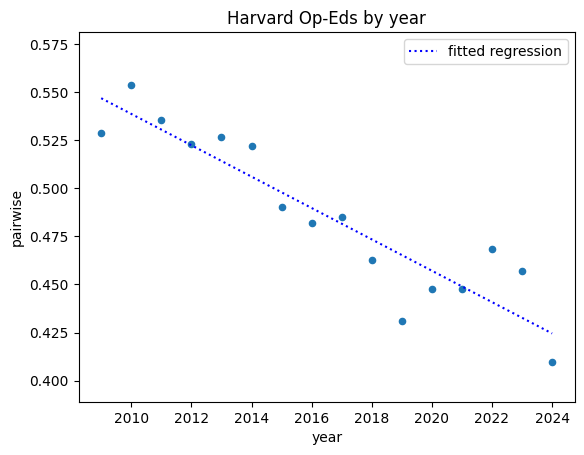

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Op-Eds by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.04203, int:0.49898, r:0.62492, p:0.00964, se:0.01403, x:range(0, 16)
pairwise slope:-0.00815, int:0.54678, r:-0.92062, p:0.00000, se:0.00092, x:range(0, 16)


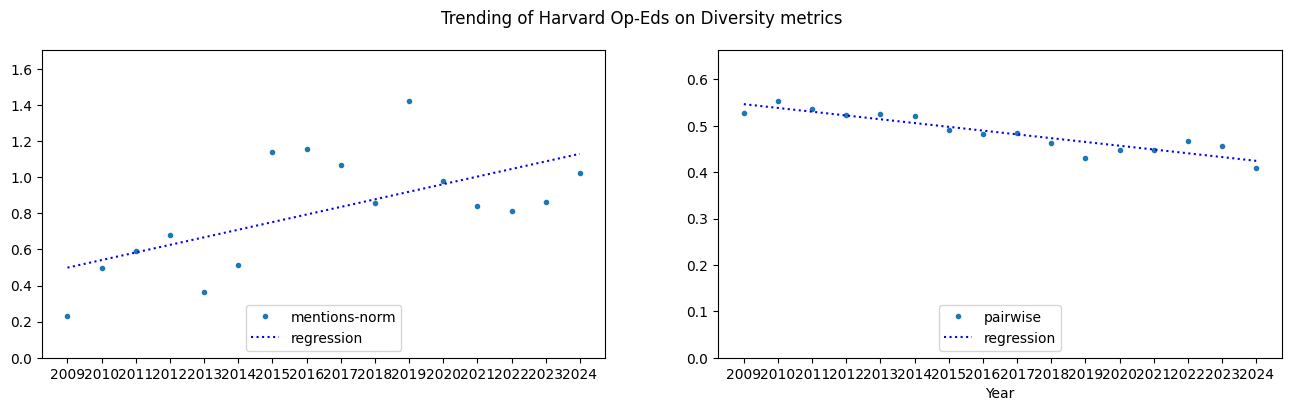

In [28]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Harvard Op-Eds on Diversity metrics")
plt.show()

In [29]:
from scipy.stats import t

confidence_level = 0.95
degrees_of_freedom = len(x) - 2
t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

margin_of_error = t_value * std_err

ci_lower = slope - margin_of_error
ci_upper = slope + margin_of_error

print(f"Slope: {slope:.5f}")
print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
print(f"Standard Error: {std_err:.5f}")
print(f"P-value: {p_value:.5f}")

Slope: -0.00815
95% Confidence Interval: (-0.01013, -0.00617)
Standard Error: 0.00092
P-value: 0.00000
